## Deep Neural Network MNIST

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [5]:
!ls

ants_and_bees  sample_data


In [6]:
!ls ants_and_bees/

train  val


In [7]:
!ls ants_and_bees/train/ants  | wc -l #one .jpeg picture which seems not to be counted.

124


In [8]:
!ls ants_and_bees/train/bees  | wc -l

121


In [9]:
!ls ants_and_bees/val/bees  | wc -l

83


In [10]:
!ls ants_and_bees/val/ants  | wc -l

70


## Data

In [0]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                #transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [12]:
print(len(training_dataset))
print (len(validation_dataset))

244
153


In [13]:
for i, j in training_loader:
  print (i.shape, j.shape)

torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([20, 3, 224, 224]) torch.Size([20])
torch.Size([4, 3, 224, 224]) torch.Size([4])


In [14]:
len(training_loader), len(training_loader.dataset)

(13, 244)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #.cpu() is needed in the testing part
    image = image.transpose(1,2,0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1) #values smaller than 0 will be converted to 0 while the ones larger than 1 will be 1
    return image

In [0]:
classes = ['ant', 'bee']

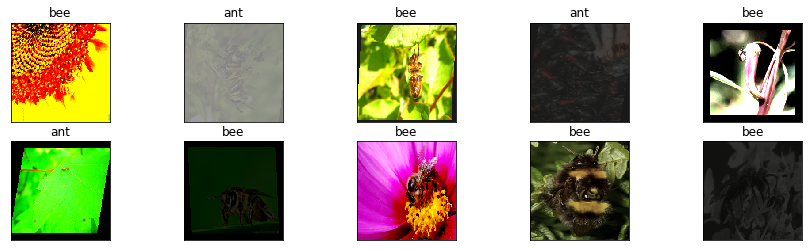

In [19]:
dataiter = iter(training_loader) #iterable
images, labels = dataiter.next()
fig = plt.figure(figsize=(15, 4))

for idx in range(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks = [], yticks=[]) #set ticks as empty
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

## Model

In [36]:
#model = models.alexnet(pretrained=True)
#model = models.vgg16(pretrained=True) 
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:08<00:00, 65024960.02it/s]


In [0]:
model = model.to(device)
#model takes 224x224 size of image. we leverage its features parameters, but train the fully connected layers
#we need to modify the last layer to only output two classes

In [38]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
#not train the feature extraction parameters
for param in model.features.parameters():
  param.requires_grad = False

In [40]:
#modify the last layer so that there are only two output clases
import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print (model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [42]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  print (e, "/", epochs)
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: #BATCH GRADIENT DESCENT
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
        

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


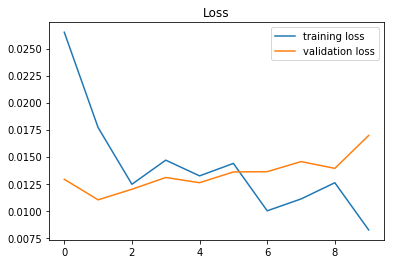

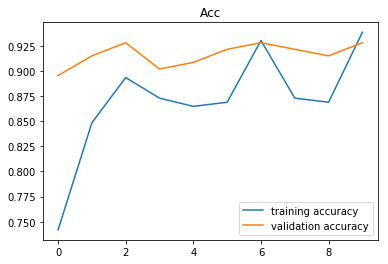

In [43]:
plt.title('Loss')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

plt.title('Acc')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

In [0]:
import PIL.ImageOps

In [0]:
import requests
from PIL import Image

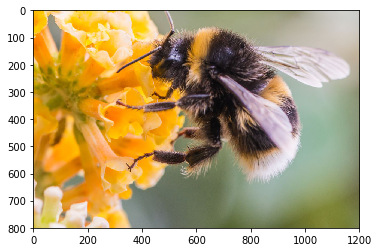

In [46]:
url = 'https://cdn.vox-cdn.com/thumbor/TdjLfYgyy54QNDooQguJSjRXD4s=/0x243:2500x2118/1200x800/filters:focal(0x243:2500x2118)/cdn.vox-cdn.com/uploads/chorus_image/image/46679984/shutterstock_150559442.0.0.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

(-0.5, 223.5, 223.5, -0.5)

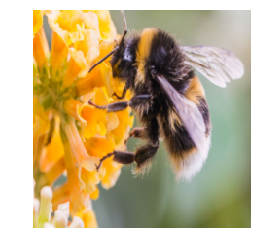

In [47]:
#img = PIL.ImageOps.invert(img) #convert to black background and white forground
#img = img.convert('1') #binary image - black white image
img = transform(img)
plt.imshow(im_convert(img))
plt.axis('off')

In [48]:
img[0].shape

torch.Size([224, 224])

In [49]:
image = img.to(device)
print (image.shape)
image = image.unsqueeze(0)#.unsqueeze(0) #into shape of (batch_size, channel, width, height)
print (image.shape)
output = model.forward(image) #it is equivalent to model(img)
_, pred = torch.max(output, 1)
print (classes[pred.item()])

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
bee


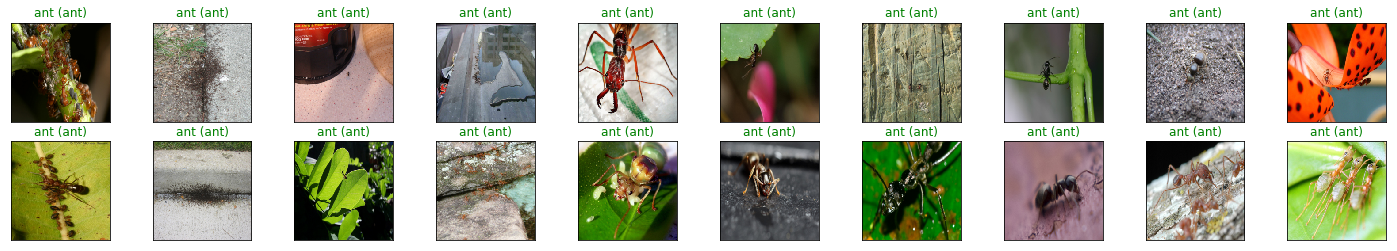

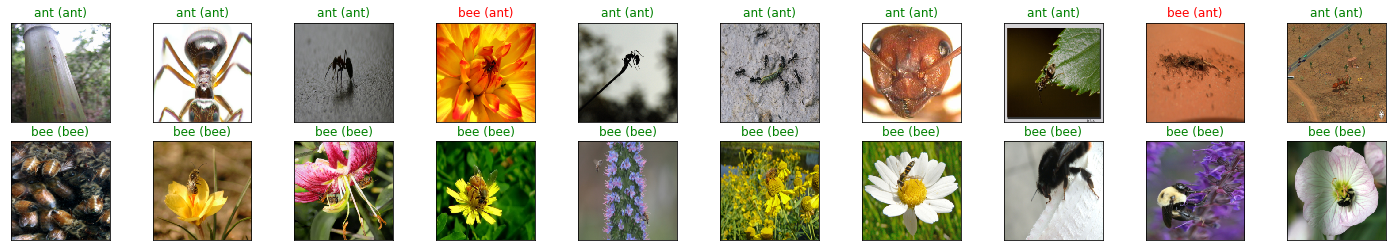

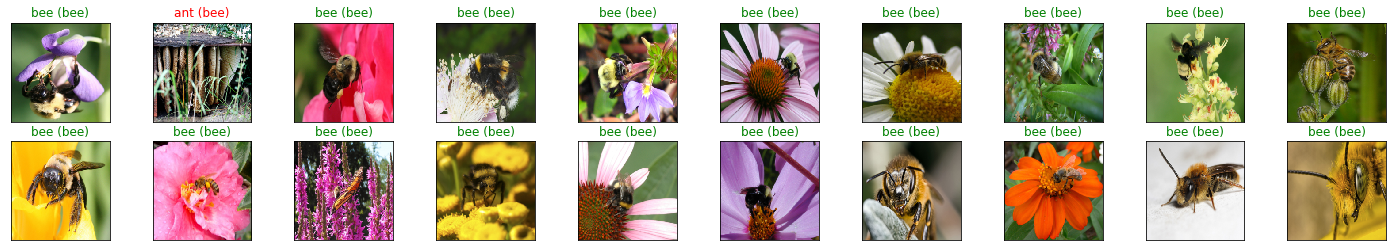

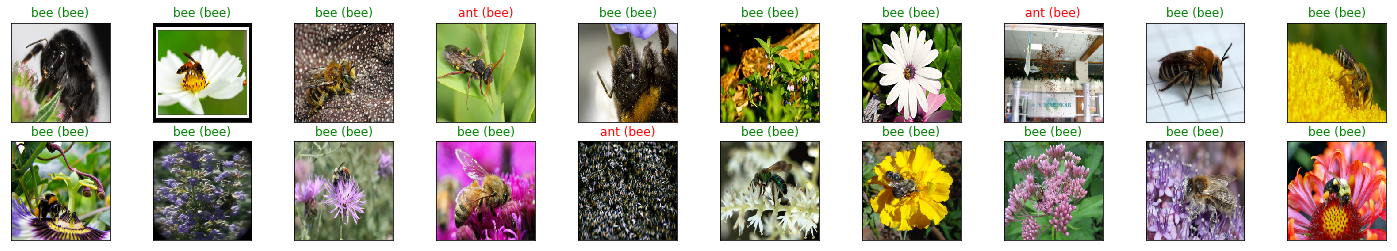

In [50]:
dataiter = iter(validation_loader)

for i in range(6):
  images, labels = dataiter.next()
  images = images.to(device) #convert tensor to cuda tensor type
  labels = labels.to(device)
  output = model(images)
  _, preds =torch.max(output, 1)

  fig = plt.figure(figsize = (25, 4))

  for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title('{} ({})'.format(classes[preds[idx].item()], classes[labels[idx].item()]), color = 'green' if preds[idx]==labels[idx] else "red")
  plt.show()